# B-Value estimates from Maximum Likelihood

Here we implement the maximum likelihood method from Tinti and Mulargia [1987]. We will compute the distribution of b-values from the stochastic event set and compare with the Comcat catalog. We will filter both the stochastic event sets and the catalog above Mw 3.95.

In [1]:
import time
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from csep.utils.plotting import plot_mfd, plot_histogram
import csep
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def bval_ml_est(mws, dmw):
    
    # compute the p term from eq 3.10 in marzocchi and sandri [2003]
    def p():
        top = dmw
        # assuming that the magnitudes are truncated above Mc (ask about this).
        bottom = np.mean(mws) - np.min(mws)
        return 1 + top / bottom
    
    bottom = np.log(10) * dmw
    return 1.0 / bottom * np.log(p())

def bval_err_est(mws, dmw):
    
    # compute the p term from eq 3.10 in marzocchi and sandri [2003]
    def p():
        top = dmw
        # assuming that the magnitudes are truncated above Mc (ask about this).
        bottom = np.mean(mws) - np.min(mws)
        return 1 + top / bottom

    top = 1 - p()
    bottom = np.log(10)*dmw*np.sqrt(len(mws)*p())
    return top / bottom

def discretize(data, bin_edges):
    """
    returns array with len(bin_edges) consisting of the discretized values from each bin. 
    instead of returning the counts of each bin, this will return an array with values 
    modified such that any value within bin_edges[0] <= x_new < bin_edges[1] ==> bin_edges[0].
    """
    n = data.shape[0]
    idx = digitize(data, bins=bin_edges)
    x_new = bin_edges[idx]
    return x_new

In [3]:
# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat').filter('magnitude >= 3.95')
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))

Fetched Comcat catalog in 19.17481803894043 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-05-31 08:55:11.616000+00:00
Min Latitude: 32.242000579833984 and Max Latitude: 41.52033233642578
Min Longitude: -124.40650177001953 and Max Longitude: -113.19066619873047
Min Magnitude: 3.950000047683716 and Max Magnitude: 6.300000190734863



In [5]:
# read in ucerf3 simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')
u3catalogs = []
for cat in csep.load_stochastic_event_set(filename=filename, format='native', type='ucerf3', name='UCERF3-ETAS'):
    u3catalogs.append(cat.filter('magnitude >= 3.95'))
    
u3catalogs_nf = []
for cat in csep.load_stochastic_event_set(filename=filename_nofaults, format='native', type='ucerf3', name='UCERF3-ETAS'):
    u3catalogs_nf.append(cat.filter('magnitude >= 3.95'))

-0.062274241045844364
18
0.9259010960645139
1.124557063250323
[0.85824281 0.86215425 0.8660657  0.86997714 0.87388859 0.87780003
 0.88171148 0.88562292 0.88953437 0.89344582 0.89735726 0.90126871
 0.90518015 0.9090916  0.91300304 0.91691449 0.92082594 0.92473738
 0.92864883 0.93256027 0.93647172 0.94038316 0.94429461 0.94820605
 0.9521175  0.95602895 0.95994039 0.96385184 0.96776328 0.97167473
 0.97558617 0.97949762 0.98340906 0.98732051 0.99123196 0.9951434
 0.99905485 1.00296629 1.00687774 1.01078918 1.01470063 1.01861208
 1.02252352 1.02643497 1.03034641 1.03425786 1.0381693  1.04208075
 1.04599219 1.04990364 1.05381509 1.05772653 1.06163798 1.06554942
 1.06946087 1.07337231 1.07728376 1.08119521 1.08510665 1.0890181
 1.09292954 1.09684099 1.10075243 1.10466388 1.10857532 1.11248677
 1.11639822 1.12030966 1.12422111 1.12813255 1.132044   1.13595544
 1.13986689 1.14377833 1.14768978 1.15160123 1.15551267 1.15942412
 1.16333556 1.16724701 1.17115845 1.1750699  1.17898135 1.18289279
 1

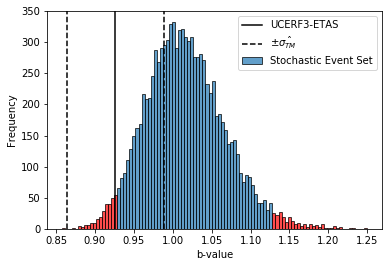

In [10]:
dmw = 0.1
b_vals = []

# get b-values from stochastic event set
for cat in u3catalogs:
    global_max = max([max(cat.get_magnitudes()), max(comcat.get_magnitudes())])
    mws = arange(3.95, global_max+2*dmw, dmw)
    cat_mws = discretize(cat.get_magnitudes(), mws)
    b_est = bval_ml_est(cat_mws, dmw)
    b_vals.append(b_est)
b_vals = np.array(b_vals)

# get b-value for comcat catalog
com_mws = discretize(comcat.get_magnitudes(), mws)
com_bval = bval_ml_est(com_mws, dmw)
com_bval_err = bval_err_est(com_mws, dmw)
print(com_bval_err)

# plot b-value estimates
fig, bin_edges, patches = hist(b_vals, bins = 100, edgecolor='black', alpha=0.7, label='Stochastic Event Set')
p25 = percentile(b_vals, 2.5)
idx_low = digitize(p25, bin_edges)
axvline(x=com_bval, color='black', linestyle='-', label='UCERF3-ETAS')
axvline(x=com_bval-com_bval_err, color='black', linestyle='--', label='$\pm\hat{\sigma_{TM}}$')
axvline(x=com_bval+com_bval_err, color='black', linestyle='--')

legend(loc='upper right')
print(idx_low)
for idx in range(idx_low):
    patches[idx].set_fc('red')
p975 = percentile(b_vals, 97.5)
idx_high = digitize(p975, bin_edges)
for idx in range(idx_high, len(patches)):
    patches[idx].set_fc('red')
print(p25)
print(p975)
print(bin_edges)

xlabel('b-value')
ylabel('Frequency')
savefig('/Users/wsavran/Projects/CSEP/Presentation/Bristol_Mar19/b_vals.pdf')
# title('b-value Estimates')


-0.062274241045844364
16
0.9224841139541583
1.1300465243993754
[0.85813811 0.86227429 0.86641048 0.87054667 0.87468285 0.87881904
 0.88295523 0.88709141 0.8912276  0.89536379 0.89949997 0.90363616
 0.90777235 0.91190853 0.91604472 0.92018091 0.92431709 0.92845328
 0.93258947 0.93672565 0.94086184 0.94499803 0.94913421 0.9532704
 0.95740659 0.96154277 0.96567896 0.96981515 0.97395133 0.97808752
 0.98222371 0.98635989 0.99049608 0.99463227 0.99876845 1.00290464
 1.00704083 1.01117701 1.0153132  1.01944939 1.02358557 1.02772176
 1.03185795 1.03599413 1.04013032 1.04426651 1.04840269 1.05253888
 1.05667507 1.06081125 1.06494744 1.06908363 1.07321981 1.077356
 1.08149219 1.08562837 1.08976456 1.09390075 1.09803693 1.10217312
 1.10630931 1.11044549 1.11458168 1.11871787 1.12285405 1.12699024
 1.13112643 1.13526261 1.1393988  1.14353499 1.14767117 1.15180736
 1.15594355 1.16007973 1.16421592 1.16835211 1.17248829 1.17662448
 1.18076067 1.18489685 1.18903304 1.19316923 1.19730541 1.2014416
 1.

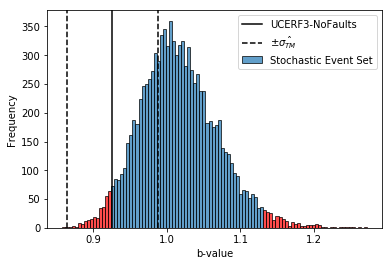

In [11]:
dmw = 0.1
b_vals = []

# get b-values from stochastic event set
for cat in u3catalogs_nf:
    global_max = max([max(cat.get_magnitudes()), max(comcat.get_magnitudes())])
    mws = arange(3.95, global_max+2*dmw, dmw)
    cat_mws = discretize(cat.get_magnitudes(), mws)
    b_est = bval_ml_est(cat_mws, dmw)
    b_vals.append(b_est)
b_vals = np.array(b_vals)

# get b-value for comcat catalog
com_mws = discretize(comcat.get_magnitudes(), mws)
com_bval = bval_ml_est(com_mws, dmw)
com_bval_err = bval_err_est(com_mws, dmw)
print(com_bval_err)

# plot b-value estimates
fig, bin_edges, patches = hist(b_vals, bins = 100, edgecolor='black', alpha=0.7, label='Stochastic Event Set')
p25 = percentile(b_vals, 2.5)
idx_low = digitize(p25, bin_edges)
axvline(x=com_bval, color='black', linestyle='-', label='UCERF3-NoFaults')
axvline(x=com_bval-com_bval_err, color='black', linestyle='--', label='$\pm\hat{\sigma_{TM}}$')
axvline(x=com_bval+com_bval_err, color='black', linestyle='--')

legend(loc='upper right')
print(idx_low)
for idx in range(idx_low):
    patches[idx].set_fc('red')
p975 = percentile(b_vals, 97.5)
idx_high = digitize(p975, bin_edges)
for idx in range(idx_high, len(patches)):
    patches[idx].set_fc('red')
print(p25)
print(p975)
print(bin_edges)

xlabel('b-value')
ylabel('Frequency')
savefig('/Users/wsavran/Projects/CSEP/Presentation/Bristol_Mar19/b_vals_nf.pdf')
# title('b-value Estimates')

## Verifying computation of $a$ from Michael [2014]

$log(N(m)) = a - bM$ <br>
$ a = log(N(m)/T) + bM $

From Table 2 in Michael [2014], <br>
$T$: 1900 $-$ 2009 <br>
$M_c:$ 7.7 <br> 
$N^{\prime}:$ 100 <br> 
$b$ = 1.59 $\pm$ 0.13

In [ ]:
Np = 100
b = 1.59
Mc = 7.7
T = 2009-1900
sigma = 0.13

def a_val(N, M, b, T):
    return np.log10(N/T) + M*b

a = a_val(Np, Mc, b, T)
print(a)

def a_err(a, b, sigma):
    return a*sigma/b

print(a_err(a, b, sigma))

In [ ]:
Np = 635
b = 1.07
Mc = 7.0
T = 2009-1918
sigma = 0.03

def a_val(N, M, b, T):
    return np.log10(N/T) + M*b

a = a_val(Np, Mc, b, T)
print(a)

def a_err(a, b, sigma):
    return sigma/b*a

print(a_err(a, b, sigma))

In [ ]:
Np = 810
b = 1.05
Mc = 6.8
T = 2009-1940
sigma = 0.03

def a_val(N, M, b, T):
    return np.log10(N/T) + M*b

a = a_val(Np, Mc, b, T)
print(a)

def a_err(a, b, sigma):
    return sigma/b*a

print(a_err(a, b, sigma))